In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
import types
import math
import pickle

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.autograd import grad

import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import boda
from boda.generator import plot_tools
from boda.common import constants

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn

from scipy import spatial
from scipy.cluster import hierarchy

from boda.generator import BasicParameters, NaiveMH, SimulatedAnnealing
from boda.generator.metropolis_hastings import PolynomialDecay
from boda.generator.energy import OverMaxEnergy

In [2]:
boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from pymeme import streme, parse_streme_output

In [3]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')

hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20210623_102310__205717.tar.gz'

unpack_artifact(hpo_rec)

model_dir = './artifacts'

my_model = model_fn(model_dir)
my_model.cuda()
my_model.eval()

left_flank = boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_UPSTREAM[-200:] 
).unsqueeze(0)
print(f'Left flanking sequence shape: {left_flank.shape}')

right_flank= boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_DOWNSTREAM[:200] 
).unsqueeze(0)
print(f'Left flanking sequence shape: {right_flank.shape}')

Loaded model from 20210623_102310 in eval mode
Left flanking sequence shape: torch.Size([1, 4, 200])
Left flanking sequence shape: torch.Size([1, 4, 200])


In [4]:
bsz = 512
step_count = 10
test_insert = dist.OneHotCategorical(logits=torch.randn(bsz,200,4)).sample().permute(0,2,1)

my_params = BasicParameters(
    nn.Parameter(test_insert), 
    left_flank.expand(bsz, -1, -1), 
    right_flank.expand(bsz, -1, -1)
)
my_energy = OverMaxEnergy(my_model, bias_cell=0)

In [5]:
mcmc = NaiveMH(my_params, my_energy)

In [6]:
samples = mcmc.collect_samples(n_samples=step_count, n_burnin=step_count)
mcmc_run = samples['samples']

  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
 10%|█         | 1/10 [00:00<00:00,  9.99it/s]

burn in


 20%|██        | 2/10 [00:00<00:00, 17.50it/s]

collect samples


100%|██████████| 10/10 [00:00<00:00, 17.32it/s]


In [7]:
mcmc_run['samples'].shape

torch.Size([10, 512, 4, 200])

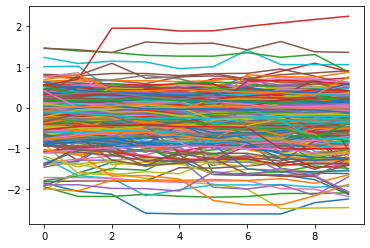

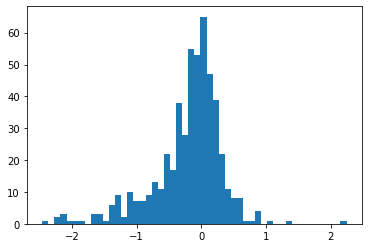

In [8]:
for i in range(test_insert.shape[0]):
    plt.plot(torch.arange(step_count),mcmc_run['energies'][:,i])
plt.show()

plt.hist( mcmc_run['energies'][-1].flatten().numpy(), bins=50 )
plt.show()

In [9]:
temp = PolynomialDecay(a=1, b=1, gamma=0.5001)
mcmc = SimulatedAnnealing(my_params, my_energy, n_positions=1, temperature_schedule=temp)

In [10]:
samples = mcmc.collect_samples(n_samples=step_count, n_burnin=0)
mcmc_run = samples['samples']

 20%|██        | 2/10 [00:00<00:00, 18.61it/s]

collect samples


100%|██████████| 10/10 [00:00<00:00, 17.53it/s]


In [11]:
mcmc_run['samples'].shape

torch.Size([10, 512, 4, 200])

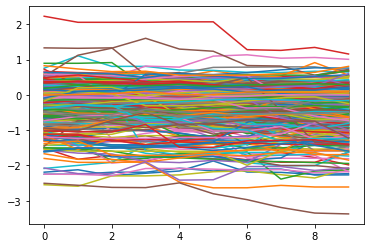

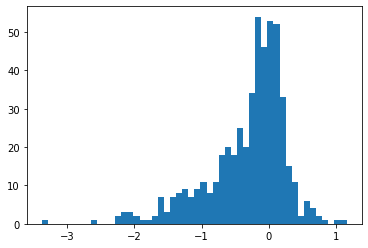

In [12]:
for i in range(test_insert.shape[0]):
    plt.plot(torch.arange(step_count),mcmc_run['energies'][:,i])
plt.show()

plt.hist( mcmc_run['energies'][-1].flatten().numpy(), bins=50 )
plt.show()

In [13]:
test_seq_file = '/home/ubuntu/boda2/analysis/SG010__pymeme/streme_test.txt'
streme_results = streme(test_seq_file)

In [14]:
my_energy.streme_penalty(streme_results)
my_energy.penalty_filters.shape

torch.Size([2, 4, 8])

In [15]:
my_energy.streme_penalty(streme_results)
my_energy.penalty_filters.shape

torch.Size([4, 4, 8])

In [17]:
my_energy.penalty( samples['samples']['samples'][0].cuda() ).shape

scores shape: torch.Size([512, 4, 193])
thresh shape: torch.Size([512, 4, 193])
mask shape: torch.Size([512, 4, 193])
masked scores shape: torch.Size([512, 4, 193])


torch.Size([512])

In [18]:
samples['samples']['samples'][0].shape

torch.Size([512, 4, 200])

In [22]:
my_energy(my_params().cuda())

scores shape: torch.Size([512, 4, 593])
thresh shape: torch.Size([512, 4, 593])
mask shape: torch.Size([512, 4, 593])
masked scores shape: torch.Size([512, 4, 593])


tensor([-1.3914e-01,  3.0698e-01, -8.4814e-01,  5.2116e-01,  9.4114e-02,
        -5.1367e-01, -1.8982e-03,  5.0076e-02, -1.3915e-01, -3.1096e-01,
        -2.2719e-02,  5.5793e-01, -2.0476e-01, -6.9445e-01,  1.5548e-01,
        -2.0719e-01, -1.5666e+00, -1.7345e-01,  1.6870e-01, -1.6101e-01,
        -2.2545e+00, -1.1053e+00,  1.1171e-01, -4.5288e-01,  8.6410e-02,
        -2.4302e-01,  4.0479e-01,  3.7318e-01, -7.2355e-01,  6.6122e-01,
         4.8795e-02, -5.8848e-01, -7.9821e-01,  4.6228e-02, -6.8216e-01,
        -1.0244e-01, -1.2875e-01, -3.2165e-01, -5.8754e-01,  3.3411e-01,
         3.7450e-01, -7.7813e-02, -6.7937e-02,  2.3711e-01,  2.6107e-01,
        -6.8335e-01,  1.8883e-01, -4.4265e-02,  1.5624e-01, -9.5507e-01,
        -2.2191e+00, -1.0437e+00, -9.4071e-01, -6.1350e-01,  4.1879e-02,
        -1.2351e-01, -8.7184e-02, -6.1807e-01, -3.8119e-01, -2.0631e-01,
        -1.6069e-02,  9.7146e-03, -4.0908e-01, -2.3764e-01, -1.0092e+00,
         3.0526e-01,  6.9594e-02, -8.0958e-02, -2.0